In [3]:
using Pkg
Pkg.activate("/mnt/dv/wid/projects4/SolisLemus-network-merging/")

using InPhyNet, PhyloNetworks
base_dir = "/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/"
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/simulation-study/simulation-scripts/helpers/helpers.jl")
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/simulation-study/simulation-scripts/helpers/est_constraints-helpers.jl")

  Activating project at `/mnt/dv/wid/projects4/SolisLemus-network-merging`
ERROR: LoadError: ArgumentError: Package InPhyNet does not have Clustering in its dependencies:
- You may have a partially installed environment. Try `Pkg.instantiate()`
  to ensure all packages in the environment are installed.
- Or, if you have InPhyNet checked out for development and have
  added Clustering as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with InPhyNet
Stacktrace:
 [1] macro expansion
   @ ./loading.jl:1634 [inlined]
 [2] macro expansion
   @ ./lock.jl:267 [inlined]
 [3] require(into::Module, mod::Symbol)
   @ Base ./loading.jl:1611
 [4] include(mod::Module, _path::String)
   @ Base ./Base.jl:457
 [5] include(x::String)
   @ InPhyNet /mnt/dv/wid/projects4/SolisLemus-network-merging/src/InPhyNet.jl:1
 [6] top-level scope
   @ /mnt/dv/wid/projects4/SolisLemus-network-merging/src/InPhyNet.jl:16
 [7] i

ErrorException: Failed to precompile InPhyNet [7d272db0-e1ce-47ab-9b64-d0002ca9962f] to "/mnt/ws/home/nkolbow/.julia/compiled/v1.9/InPhyNet/jl_X0dEix".

#### Load and Examine Data

In [2]:
est_gts = readMultiTopology(joinpath(base_dir, "data", "Best.FAA.tre"))
length(est_gts)

410

*Lots* of spread in the estimated gene trees on who is included

┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends.jl:43


min: 38, max: 1131
total unique names: 1178


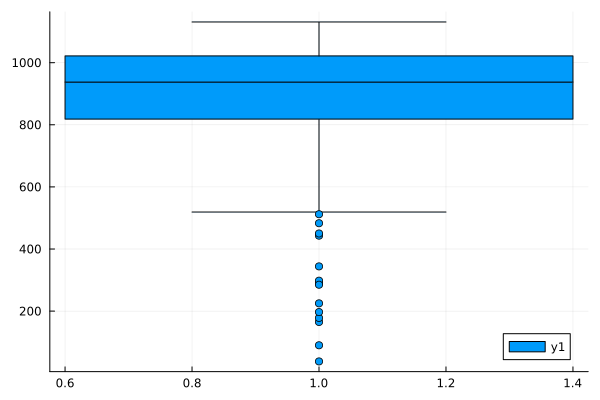

In [3]:
using Plots, StatsPlots
ntaxas = [t.numTaxa for t in est_gts]
println("min: $(minimum(ntaxas)), max: $(maximum(ntaxas))")
uq_names = Set()
for t in est_gts
    union!(uq_names, [l.name for l in t.leaf])
end
println("total unique names: $(length(uq_names))")

boxplot(ntaxas)

In [16]:
name_vec = Vector(collect(keys(uq_names.dict)))
name_map = Dict([name_vec[i] => i for i=1:length(uq_names)])
counts = zeros(length(uq_names))
for gt in est_gts
    for leaf in gt.leaf
        counts[name_map[leaf.name]] += 1
    end
end
minimum(counts), maximum(counts)

(75.0, 398.0)

## Subset decomposition

In [3]:
est_D, est_namelist = calculateAGIC(est_gts)
nj_tre = nj(DataFrame(est_D, est_namelist), force_nonnegative_edges=true)

┌ Info: 4 branches had negative lengths, reset to 0
└ @ PhyloNetworks /mnt/ws/home/nkolbow/.julia/packages/PhyloNetworks/V8OaV/src/nj.jl:140


HybridNetwork, Un-rooted Network
2353 edges
2354 nodes: 1178 tips, 0 hybrid nodes, 1176 internal tree nodes.
tip labels: AALA, AAXJ, ABCD, ABEH, ...
(((((((((((((((((((((((AALA:2.504,(((((AUGV:0.711,(UDHA:0.677,ZGQD:1.082):0.147):1.583,NMGG:1.115):0.84,(((((BEKN:1.083,(QCOU:0.857,RQNK:0.717):0.558):0.105,SSDU:0.896):1.59,IRAF:0.727):1.325,(XHKT:0.927,XMVD:1.085):0.478):0.181,EVOD:1.312):1.355):1.738,(((((Aquco_v1.1:0.491,GBVZ:0.667):1.11,(UPOG:0.488,ZUHO:0.536):1.235):0.937,VGHH:0.993):1.13,(WFBF:0.986,YHFG:0.917):1.138):1.123,CCID:1.698):0.312):0.159,QTJY:1.859):1.448):0.237,((FAKD:0.713,Nelnu_v1.0:0.435):2.085,((GRRW:0.743,(RQUG:0.462,SIIK:0.614):0.64):2.09,VQFW:1.823):0.321):0.614):0.243,SWOH:2.258):0.304,((((((((((((((((((((((ABCD:0.745,RDOO:0.465):1.936,((FFPD:1.482,GRKU:1.25):0.59,NGTD:1.656):0.19):0.183,(RGKI:0.602,VMXJ:0.429):2.042):0.681,BPSG:1.534):0.95,((((BGXB:1.622,(JMXW:0.523,XWHK:0.629):1.706):0.587,(CMEQ:1.385,((DHWX:2.063,(((((EEMJ:1.851,LNSF:1.887):0.53,(((JADL:1.685,

In [4]:
subsets = sateIdecomp(nj_tre, 25)
println(sort([length(s) for s in subsets])[1:5])
println(maximum([length(s) for s in subsets]))
println(length(subsets))

[11, 11, 11, 12, 12]
25
67


## Generate Condor data

Outline:

We use stopping rules to decide the number of retics in each subnet, so
1. if no snaq file exists yet, submit runs w/ h=0,1
2. if snaq files exist, load last 2 runs and check if another should be submitted with the function `should_stop_AIC`

This code should build the submit file's tables from scratch each time so that runs are never re-submitted.

In [5]:
df_dir = "data/CFs/"
init_dir = "data/init_trees/"
out_dir = "data/snaq_outputs/"
tab_file = "condor/inputs.tab"
best_tree = readTopology("data/Best.FAA.tre")

open(tab_file, "a+") do tab_io
    # For now just queue all of them with h=0, 1, 2 b/c it's easier...
    for (i, subset_taxa) in enumerate(subsets)
        @info i

        temp_gts = Array{HybridNetwork}(undef, length(est_gts))
        for i = 1:length(est_gts)
            if length(intersect([l.name for l in est_gts[i].leaf], subset_taxa)) >= 4
                temp_gts[i] = pruneTruthFromDecomp(est_gts[i], subset_taxa)
            end
        end
        temp_gts = temp_gts[findall(i -> isassigned(temp_gts, i), 1:length(temp_gts))]

        # 1. count quartets
        q, t = silently() do
            countquartetsintrees([t for t in temp_gts if length(t.leaf) >= 4])
        end
        df = silently() do
            readTableCF(writeTableCF(q, t))
        end
        CSV.write(joinpath(df_dir, "df_$(i).csv"), writeTableCF(df))

        # 2. save starting tree
        init_tree = pruneTruthFromDecomp(best_tree, subset_taxa)
        writeTopology(init_tree, joinpath(init_dir, "init_$(i).tre"))

        # 3. Write info to Condor input table
        write(tab_io, "$(i),0\n")
        write(tab_io, "$(i),1\n")
        write(tab_io, "$(i),2\n")
    end
end

┌ Info: 1
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 2
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 3
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 4
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 5
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 6
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 7
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 8
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 9
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/analysis.ipynb:10
┌ Info: 10
└ @ Main /mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-stu

## Infer constraints

This is done in Condor with the submit file `empirical-study/condor/submit.submit`

## InPhyNet

In [2]:
df = readTableCF("/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/data/CFs/df_1.csv")
tre0 = readTopology("/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/data/init_trees/init_1.tre")

UndefVarError: UndefVarError: `readTableCF` not defined